# Análisis estadístico distribuciones variables dependientes


El modelo de clasificación binaria construido para predecir propinas de alto monto en los viajes de taxis en New York, fue entrenado con data de Enero 2020 (con una muestra aleatoria de 1 millón), logrando para la train data un F1 score de **0.73**.  Luego, al ocupar dicho modelo para predecir data de Abril 2020, dicha métrica baja considerablemente a **0.61**. Dado este cambio abrupto (que se desprende se debe al efecto pandemia que justo comenzó en esa fecha) la idea es validar que efectivamente ocurrió un cambio en las poblaciones a nivel estadístico.

Para ello se analizarán las distribuciones de las variables predictivas utilizadas en el modelo, para los periodos de Ene-2020 a Jun-2020

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

In [30]:
#Cargamos el modelo construido:
loaded_rfc = joblib.load('/models/random_forest.joblib')


## **1. Extracción datos**

Creamos una funcióna llamada **"load_data"** que cargará el mes de datos que necesitemos:

In [2]:
def load_data(year: int, month: int) -> pd.DataFrame:
    """Read the data for a given year and month."""
    filename = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02}.parquet"
    return pd.read_parquet(filename)

In [3]:
#Definimos parámetros
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

target_col = "high_tip"

Definimos también la función "preprocess" que dado un dataframe y el nombre de la columna target, entregaran como utput otro datafame preprocesado con lascolumans necesarias para predecir con el modelo:

In [4]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)

In [33]:
#Extraemos la data desde la web para los 6 meses que van de Enero a Junio de 2020
taxi_1 = load_data(2020,1)
taxi_2 = load_data(2020,2)
taxi_3 = load_data(2020,3)
taxi_4 = load_data(2020,4)
taxi_5 = load_data(2020,5)
taxi_6 = load_data(2020,6)

In [34]:
#Vemos el número de registros por mes
print(f'Taxi 1 tiene {len(taxi_1)} registros')
print(f'Taxi 2 tiene {len(taxi_2)} registros')
print(f'Taxi 3 tiene {len(taxi_3)} registros')
print(f'Taxi 4 tiene {len(taxi_4)} registros')
print(f'Taxi 5 tiene {len(taxi_5)} registros')
print(f'Taxi 6 tiene {len(taxi_6)} registros')

Taxi 1 tiene 6405008 registros
Taxi 2 tiene 6299367 registros
Taxi 3 tiene 3007687 registros
Taxi 4 tiene 238073 registros
Taxi 5 tiene 348415 registros
Taxi 6 tiene 549797 registros


Definimos otra función **"extraer_variable"** que recibiendo como input el nombre de la variable de interés, extrae ésta para los 4 meses, en una lista. Probablemente usaremos esta función más adelante para graficar:

In [9]:
def extraer_variable(nombre_variable):
  dataframes = [taxi_1_procesado[nombre_variable].to_frame(), taxi_2_procesado[nombre_variable].to_frame(), taxi_3_procesado[nombre_variable].to_frame(), taxi_4_procesado[nombre_variable].to_frame()]
  return dataframes

## **2. Cálculo score F1**

El F1 score es un estimador que nos habla de la capacidad de clasificación de un modelo, midiendo la performance de la precisión y el recall.
Sabiendo que el modelo predictivo se entrenó con una muestra aleatoria de 1 millón de Enero-2020, veamos como se comporta la métrica F1 al predecir de Enero a Mayo:


In [35]:
taxi_1_procesado = preprocess(taxi_1, target_col)
taxi_2_procesado = preprocess(taxi_2, target_col)
taxi_3_procesado = preprocess(taxi_3, target_col)
taxi_4_procesado = preprocess(taxi_4, target_col)
taxi_5_procesado = preprocess(taxi_5, target_col)
taxi_6_procesado = preprocess(taxi_6, target_col)

In [37]:
preds_ene = loaded_rfc.predict_proba(taxi_1_procesado[features])
preds_feb = loaded_rfc.predict_proba(taxi_2_procesado[features])
preds_mar = loaded_rfc.predict_proba(taxi_3_procesado[features])
preds_abr = loaded_rfc.predict_proba(taxi_4_procesado[features])
preds_may = loaded_rfc.predict_proba(taxi_5_procesado[features])
preds_jun = loaded_rfc.predict_proba(taxi_6_procesado[features])

In [39]:
preds_ene_labels = [p[1] for p in preds_ene.round()]
preds_feb_labels = [p[1] for p in preds_feb.round()]
preds_mar_labels = [p[1] for p in preds_mar.round()]
preds_abr_labels = [p[1] for p in preds_abr.round()]
preds_may_labels = [p[1] for p in preds_may.round()]
preds_jun_labels = [p[1] for p in preds_jun.round()]

f1_ene = f1_score(taxi_1_procesado[target_col], preds_ene_labels)
f1_feb = f1_score(taxi_2_procesado[target_col], preds_feb_labels)
f1_mar = f1_score(taxi_3_procesado[target_col], preds_mar_labels)
f1_abr = f1_score(taxi_4_procesado[target_col], preds_abr_labels)
f1_may = f1_score(taxi_5_procesado[target_col], preds_may_labels)
f1_jun = f1_score(taxi_6_procesado[target_col], preds_jun_labels)

print(f'F1 enero: {f1_ene}')
print(f'F1 febrero: {f1_feb}')
print(f'F1 marzo: {f1_mar}')
print(f'F1 abril: {f1_abr}')
print(f'F1 mayo: {f1_may}')
print(f'F1 junio: {f1_jun}')

F1 enero: 0.7297114839706142
F1 febrero: 0.7349927704696302
F1 marzo: 0.725934609337867
F1 abril: 0.6117247729611642
F1 mayo: 0.6166028484960244
F1 junio: 0.6478467365923725


In [41]:
lista_f1 = []
lista_f1.append(f1_ene)
lista_f1.append(f1_feb)
lista_f1.append(f1_mar)
lista_f1.append(f1_abr)
lista_f1.append(f1_may)
lista_f1.append(f1_jun)

In [44]:
lista_meses = ['ene-20','feb-20', 'mar-20', 'abr-20','may-20','jun-20']

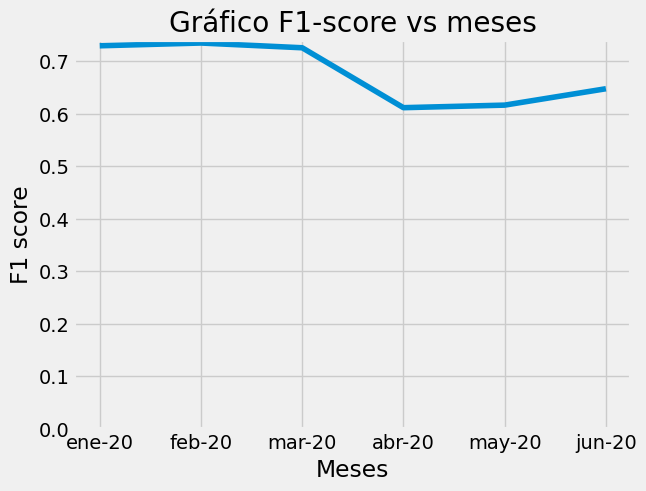

In [47]:
plt.plot(lista_f1)
plt.xticks(ticks=range(len(lista_meses)), labels=lista_meses)

plt.title('Gráfico F1-score vs meses')
plt.xlabel('Meses')
plt.ylabel('F1 score')
plt.ylim(bottom=0)

# Mostrar el gráfico
plt.show()

Vemos claramente cómo de marzo a abril baja F1 score, lo que no sorprende pues sabemos a mediados de marzo comenzó mundialmente a implementarse cuarentenas por la pandemia de COVID

## **3. Distribuciones de las variables**

Cualitativamente sabemos que el descenso en la performance del modelo se debe a que el contexto y el comportamiento del usuario cambió por la pandemia. Para demostrar esto de manera estadística realizaremos una prueba K-S (Kolmogorov-Smirnov), prueba no paramétrica que mide la bondad de ajuste entre 2 distribuciones.

Para asegurarnos que el tamaño de las poblaciones sea igual, tomaremos muestras aleatorias de 200.000:

In [48]:
taxi_1_procesado = taxi_1_procesado.sample(200000)
taxi_2_procesado = taxi_2_procesado.sample(200000)
taxi_3_procesado = taxi_3_procesado.sample(200000)
taxi_4_procesado = taxi_4_procesado.sample(200000)
taxi_5_procesado = taxi_5_procesado.sample(200000)
taxi_6_procesado = taxi_6_procesado.sample(200000)

In [50]:
taxi_1_procesado.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
554409,2020-01-04 11:48:00,5.0,11.0,0.0,28.0,2.0,3.35,1141.0,0.002936,41.0,50.0,1.0,0
4945004,2020-01-25 16:42:50,5.0,16.0,0.0,40.0,1.0,0.31,119.0,0.002605,141.0,141.0,1.0,0
6376966,2020-01-29 00:19:00,2.0,0.0,0.0,4.0,-1.0,3.23,900.0,0.003589,188.0,61.0,-1.0,0
2275572,2020-01-12 22:26:55,6.0,22.0,0.0,22.0,1.0,1.32,252.0,0.005238,48.0,68.0,1.0,1
3078154,2020-01-16 18:25:37,3.0,18.0,1.0,15.0,1.0,1.90,598.0,0.003177,237.0,238.0,1.0,0


In [53]:
def compare_distributions(dfa: pd.DataFrame, dfb: pd.DataFrame):
    """Compare the distributions of two datasets."""
    from scipy import stats
    statistics = []
    p_values = []

    for feature in features:
        statistic, p_value = stats.ks_2samp(dfa[feature], dfb[feature])
        statistics.append(statistic)
        p_values.append(p_value)

    comparison_df = pd.DataFrame(data={'feature': features, 'statistic': statistics, 'p_value': p_values})
    comparison_df.sort_values(by='p_value', ascending=True).head(11)

    return comparison_df

Comparamos entre Enero y Abril:

In [58]:
comparison_df = compare_distributions(taxi_1_procesado, taxi_4_procesado)
comparison_df.sort_values(by='p_value', ascending=True)

,feature,statistic,p_value
0,pickup_weekday,0.065955,0.000000e+00
1,pickup_hour,0.111560,0.000000e+00
2,work_hours,0.106995,0.000000e+00
4,passenger_count,0.118690,0.000000e+00
6,trip_time,0.177435,0.000000e+00
7,trip_speed,0.376110,0.000000e+00
8,PULocationID,0.110415,0.000000e+00
9,DOLocationID,0.103590,0.000000e+00
10,RatecodeID,0.073230,0.000000e+00
5,trip_distance,0.050395,3.719930e-221


Vemos cómo todos los p-valor arrojan menor a 0.05 (excepto la variable pickup_minute), lo que indica que de Enero a Abril se comprueba estadísticamente un cambio en la distribución de las variables explicativas, lo que se tradujo en una baja del rendimiento del modelo.

Por ejemplo, comprobando gráficamente la distribución de la variable trip_distance:

In [60]:
# Variable trip_distance

#1. Extraer Variable
dataframes = extraer_variable('trip_distance')

#2. Iterar sobre la lista de dataframes: reemplazar valores negativos y luego eliminar 1% más alto y más bajo para excluir potenciales outliers
for i in range(4):
    df = dataframes[i]
    df1 = df[df['trip_distance'] > 0] #quito valores inferiores a 1 (no puede haber 0 pasajeros o negativo)
    df1 = df1.sort_values(by='trip_distance', ascending=True).reset_index(drop=True) #ordeno data de menor a mayor

    num_filas = len(df1)
    num_filas_a_eliminar = int(num_filas * 0.01)

    #Filtrar el dataframe eliminando el 1% más bajo y más alto en 'work_hours'
    df2 = df1[num_filas_a_eliminar:-num_filas_a_eliminar]

    #reemplazar antiguo por procesado
    dataframes[i]=df2

In [61]:
dataframes[3]

,trip_distance
1949,0.200000
1950,0.200000
1951,0.200000
1952,0.200000
1953,0.200000
...,...
193003,19.059999
193004,19.059999
193005,19.059999
193006,19.059999


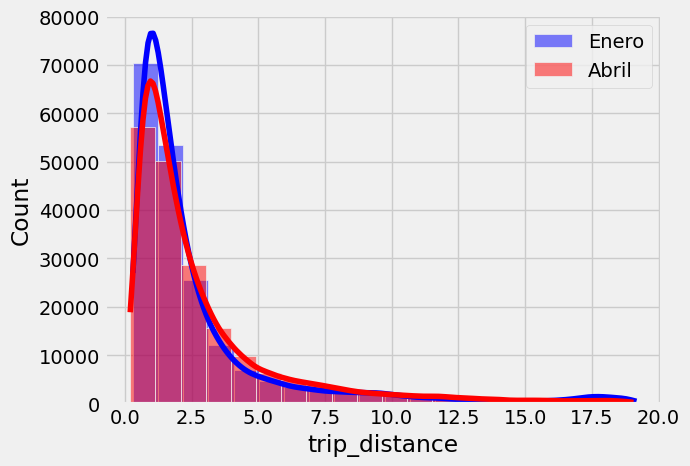

In [64]:

sns.histplot(data= dataframes[0], x='trip_distance', bins=20, kde=True, label='Enero', color='blue')

sns.histplot(data= dataframes[3], x='trip_distance', bins=20, kde=True, label='Abril', color='red')
plt.legend()
plt.show()

Vemos cómo las curvas muestran un comportamiento un tanto distinto (En Abril se "achata" un tanto)